In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.abspath(os.path.join('../')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from mlmodels.linear_models import LASSO
from helper_libraries.model_pipeline import *
from helper_libraries.forecasting_tools import *
from tqdm.auto import tqdm
import datetime as dt
import sklearn.preprocessing
import sklearn.utils
import unittest

# Outline

* Load some sample data for testing
* Run tests on different sets of functions

# Load Data

In [2]:
# Set up some sample data for the tests
sample_data_df = pd.read_parquet('../../data/proc/_temp/1996_all.parquet')

# Load data
iris_df = sns.load_dataset('iris')
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Tests - Pipeline

## Full Example

In [4]:
# Set up in sample data
np.random.seed(1)
ins_frac = 0.1
iris_ins_df = iris_df.sample(70).reset_index(drop = True)
iris_oos_df = iris_df.sample(70).reset_index(drop = True)

Y_ins = iris_ins_df[['petal_length']]
X_ins = iris_ins_df[['petal_width', 'sepal_length', 'sepal_width']]
Y_oos = iris_oos_df[['petal_length']]
X_oos = iris_oos_df[['petal_width', 'sepal_length', 'sepal_width']]

# Run models
model_lasso = LASSO({'lambda': 1e-5, 'use_intercept': False, 'seed': 5})
model_list = [model_lasso]

# Split into train/validate for optimal hyperparams
mtrain = ModelTrainer([model_lasso], Y_ins, X_ins, seed = 444)
mtrain.validation(frac=0.5, n_iter = 200)

# Testing
mtest = ModelTester(mtrain)
model_forecasts = mtest.forecast(Y_oos, X_oos)

### View results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   true   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.664e+04
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                    5.36e-84
Time:                        17:01:40   Log-Likelihood:                         -9.4818
No. Observations:                  70   AIC:                                      20.96
Df Residuals:                      69   BIC:                                      23.21
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
forecast       0.9961      0.008    129.003      0.000       0.981       1.011
==============================================================================
Omnibus:                        2.280   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.320   Jarque-Bera (JB):                1.547
Skew:                           0.226   Prob(JB):                        0.461
Kurtosis:                       3.571   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='forecast', ylabel='true'>

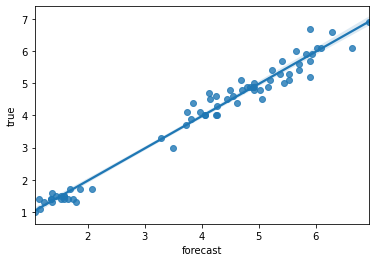

In [5]:
results_df = pd.concat(
    [
        model_forecasts[0].rename(columns={"petal_length": "forecast"}),
        Y_oos.rename(columns={"petal_length": "true"}),
    ],
    axis=1,
)

display(smf.ols('true ~ forecast - 1', data = results_df).fit().summary())

sns.regplot(x = 'forecast', y = 'true', data = results_df)

## Unit Tests
Use this only after running full pipeline

In [6]:
class TestPipelineFunctions(unittest.TestCase):
    
    def test_scaling(self):

        mtrain = ModelTrainer([model_lasso], Y_ins, X_ins, seed = 444)
        mtrain.validation(frac=0.5, n_iter=2)
        self.assertEqual(np.all(np.std(mtrain.X_train_scl, axis = 0)==1), 1)

In [7]:
unittest.main(argv=[''], verbosity=2, exit=False);

test_scaling (__main__.TestPipelineFunctions) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


# Tests - Rollers

## Full Example

In [20]:
## Example params

# Create some models
model_lasso = LASSO({'lambda': 1e-5, 'use_intercept': False, 'seed': 5})
model_lasso2 = LASSO({'lambda': 1e-5, 'use_intercept': False, 'seed': 5})
model_list = [model_lasso, model_lasso2]

# Define your data
Y = sample_data_df[['ff__mkt']]
X = sample_data_df[['ff__hml']].shift(1).bfill()

In [21]:
# This function is passed into the produce_forecasts_*** function
# and applied on whatever basis
def forecasting_pipeline(model_list, Y_ins, X_ins, Y_oos, X_oos):
    
    # Output variables
    forecast_log = {}
    
    # Train the algos
    mtrain = ModelTrainer(model_list, Y_ins, X_ins, seed=444)
    mtrain.validation()
    forecast_log['hyperparameters'] = mtrain.model_hyperparameters_opt

    # Produce OOS forecasts
    mtest = ModelTester(mtrain)
    oos_forecasts = mtest.forecast(Y_oos, X_oos)
    forecast_output = oos_forecasts
    
    return forecast_output, forecast_log

In [22]:
## Rolling implementation of models to get rolling forecasts
forecast_output, forecast_log = produce_forecasts_rolling(Y, X, model_list, forecasting_pipeline, ins_window="30d", oos_window="5d")

### View results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          ff__mkt_truth   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              28.70
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                    8.77e-08
Time:                        17:04:45   Log-Likelihood:                          32716.
No. Observations:                6264   AIC:                                 -6.543e+04
Df Residuals:                    6263   BIC:                                 -6.542e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
ff__mkt_forecast     0.7272      0.136      5.357      0.000       0.461       0.993
==============================================================================
Omnibus:                     3580.589   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           469620.798
Skew:                          -1.749   Prob(JB):                         0.00
Kurtosis:                      45.274   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

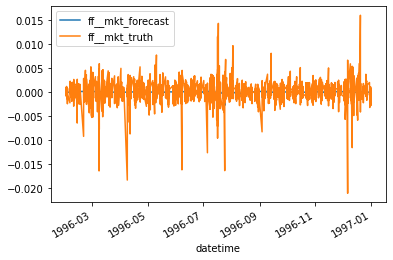

In [23]:
# Each element of this list contains a dataframe of forecasts
# for a particular model in model_list
forecast_output_list = [pd.concat(pd.DataFrame(forecast_output).T[col].values) for col in range(len(model_list))]

# Get forecasts for the first model
model_forecasts_example_df = forecast_output_list[0]
model_forecasts_example_df = (
    model_forecasts_example_df.reset_index()
    .merge(Y.reset_index(), on="datetime", suffixes=("_forecast", "_truth"), how="left")
    .set_index("datetime")
)
display(
    sm.OLS(model_forecasts_example_df.iloc[:, 1], model_forecasts_example_df.iloc[:, 0]).fit().summary()
)
model_forecasts_example_df.plot();

## Check rolling windows
Visualize the windows used by the produce_forecasts_*** functions
Can specify expanding kwarg as true or false

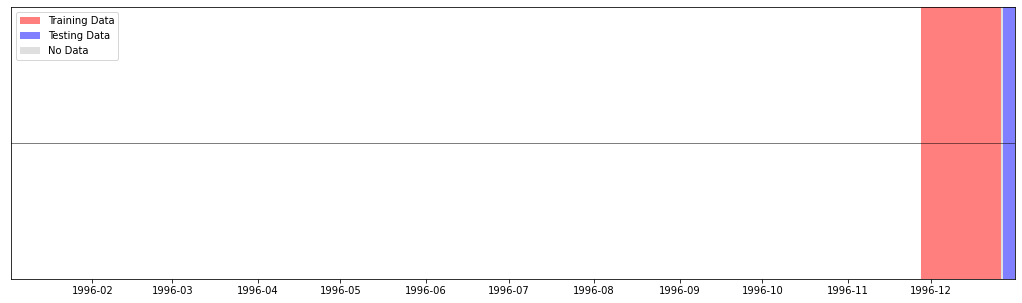

In [47]:
# Set up figure
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(111)
plt.close()
hfig = display(fig, display_id=True)

# Params
date_zero = Y.index[0]
date_stop = Y.index[-1]

# Initial draw
ax.plot([date_zero, date_stop], [0, 0], color="k", alpha=0.5, lw=1)
ax.set_xlim(date_zero, date_stop)
ax.set_yticks([])
fig.canvas.draw()
hfig.update(fig)

# This function plots the windows using the indices of the
# in-sample and out-of-sample data
def plot_windows(_, Y_ins, X_ins, Y_oos, X_oos):
    
    # Get windows
    date_ins_start = Y_ins.index[0]
    date_ins_end = Y_ins.index[-1]
    date_oos_start = Y_oos.index[0]
    date_oos_end = Y_oos.index[-1]

    # Plot new windows
    ax.cla()
    ax.axvspan(date_ins_start, date_ins_end, color="r", alpha=0.5, label="Training Data", lw=0)
    ax.axvspan(date_oos_start, date_oos_end, color="b", alpha=0.5, label="Testing Data", lw=0)
    ax.axvspan(date_ins_end, date_oos_start, color="silver", alpha=0.5, label="No Data", lw=0)
    ax.plot([date_zero, date_stop], [0, 0], color="k", alpha=0.5, lw=1)
    ax.set_xlim(date_zero, date_stop)
    ax.set_yticks([])
    ax.legend(loc="upper left")

    # Update figure
    fig.canvas.draw()
    hfig.update(fig)

    return None, {}

In [48]:
# Rolling implementation of models to get rolling forecasts
forecast_output, forecast_log = produce_forecasts_rolling(
    Y, X, model_list, plot_windows, ins_window="30d", oos_window="5d", expanding = False
)